In [2]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [3]:
import os
import numpy as np
import netCDF4 as nc
import xarray as xr
import datatree as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sithom.plot import plot_defaults, label_subplots, lim
from tcpips.constants import DATA_PATH, FIGURE_PATH
from adforce.mesh import xr_loader

plot_defaults()

In [4]:
station_nc = xr_loader("../../kat.nws13.2004/fort.61.nc")
station_nc

/work/n01/n01/sithom/miniconda3/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


'xr_loader'  11.07373 s 



<xarray.Dataset>
Dimensions:       (time: 1344, station: 83)
Coordinates:
  * time          (time) datetime64[ns] 2004-08-01T00:15:00 ... 2004-08-15
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            1060562
    grid_type:          Triangular
    description:        ﻿ASGS      ! 32 CHARACTER ALPHANUMERIC RUN DESCRIPTION
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

In [5]:
met_stat = xr_loader("../../kat.nws13.2004/fort.71.nc")
met_stat

'xr_loader'  0.37707 s 



<xarray.Dataset>
Dimensions:       (time: 336, station: 83)
Coordinates:
  * time          (time) datetime64[ns] 2004-08-01T01:00:00 ... 2004-08-15
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    pressure      (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            1060562
    grid_type:          Triangular
    description:        ﻿ASGS      ! 32 CHARACTER ALPHANUMERIC RUN DESCRIPTION
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

In [6]:
met_stat = xr_loader("../../kat.nws13.2004/fort.71.nc", use_dask=True)
met_stat

'xr_loader'  1.61095 s 



<xarray.Dataset>
Dimensions:       (time: 336, station: 83)
Coordinates:
  * time          (time) datetime64[ns] 2004-08-01T01:00:00 ... 2004-08-15
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 dask.array<chunksize=(83,), meta=np.ndarray>
    x             (station) float64 dask.array<chunksize=(83,), meta=np.ndarray>
    y             (station) float64 dask.array<chunksize=(83,), meta=np.ndarray>
    pressure      (time, station) float64 dask.array<chunksize=(1, 83), meta=np.ndarray>
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            1060562
    grid_type:          Triangular
    description:        ﻿ASGS      ! 32 CHARACTER ALPHANUMERIC RUN DESCRIPTION
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

In [7]:
met_stat = xr_loader("../../kat.nws13.2004/fort.72.nc", use_dask=True)
met_stat

'xr_loader'  0.04080 s 



<xarray.Dataset>
Dimensions:       (time: 336, station: 83)
Coordinates:
  * time          (time) datetime64[ns] 2004-08-01T01:00:00 ... 2004-08-15
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 dask.array<chunksize=(83,), meta=np.ndarray>
    x             (station) float64 dask.array<chunksize=(83,), meta=np.ndarray>
    y             (station) float64 dask.array<chunksize=(83,), meta=np.ndarray>
    windx         (time, station) float64 dask.array<chunksize=(1, 83), meta=np.ndarray>
    windy         (time, station) float64 dask.array<chunksize=(1, 83), meta=np.ndarray>
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            1060562
    grid_type:          Triangular
    description:        ﻿ASGS      ! 32 CHARACTER ALPHANUMERIC RUN DESCRIPTION
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

In [8]:
station_nc

<xarray.Dataset>
Dimensions:       (time: 1344, station: 83)
Coordinates:
  * time          (time) datetime64[ns] 2004-08-01T00:15:00 ... 2004-08-15
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            1060562
    grid_type:          Triangular
    description:        ﻿ASGS      ! 32 CHARACTER ALPHANUMERIC RUN DESCRIPTION
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

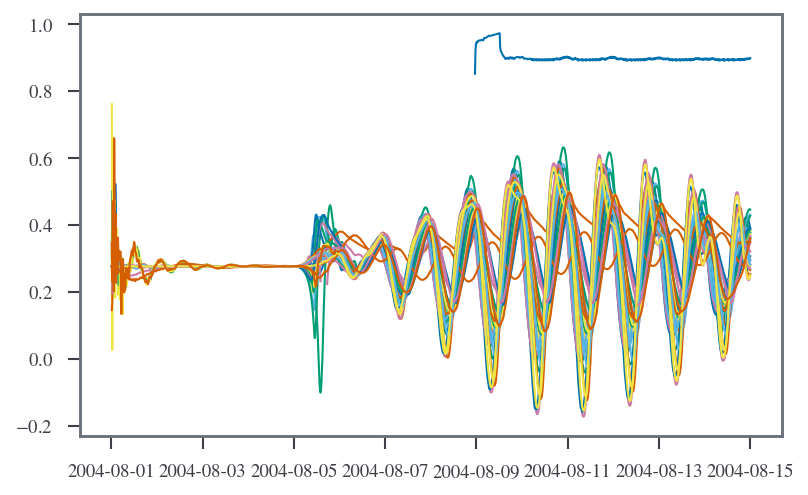

In [9]:
plt.plot(station_nc.time.values, station_nc.zeta.values)

In [10]:
from adforce.mesh import select_coast_mesh, select_coast, plot_contour
f63 = xr_loader("../../kat.nws13.2004/fort.63.nc")
indices, adj = select_coast(f63, overtopping=True, keep_sparse=True)
f63_coast = f63.isel(node=indices)
x_values, y_values = f63_coast.x.values, f63_coast.y.values

'xr_loader'  0.03374 s 

'calculate_adjacency_matrix'  0.24920 s 

'select_coast'  1.42440 s 



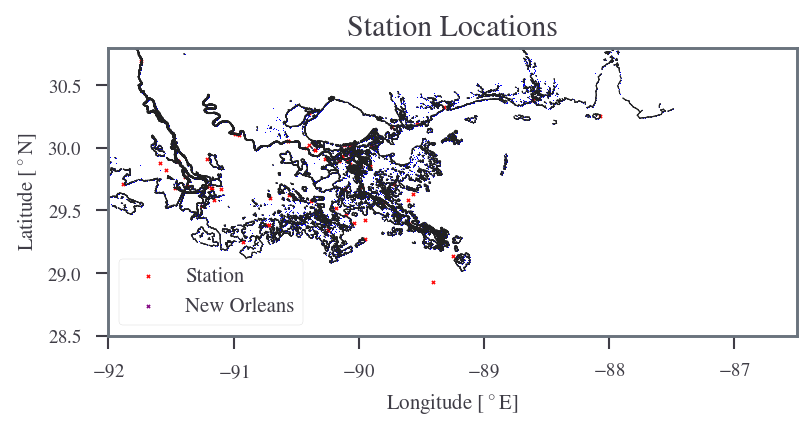

In [11]:
from src.constants import NEW_ORLEANS, NO_BBOX
from adforce.mesh import select_coast_mesh, select_coast, plot_contour
ax = plt.gca()
plot_contour(ax, x_values, y_values, adj)
plt.scatter(station_nc.x.values, station_nc.y.values, s=3, color="red", label="Station")
plt.scatter(NEW_ORLEANS.lon, NEW_ORLEANS.lat, c="purple", s=3, label="New Orleans")
plt.xlabel("Longitude [$^\circ$E]")
plt.ylabel("Latitude [$^\circ$N]")
plt.title("Station Locations")
plt.legend()
NO_BBOX.ax_lim(ax)
ax.set_aspect("equal")

In [12]:
from adforce.fort22 import read_fort22

In [13]:
read_fort22("../../kat.nws13.2004/fort.22.nc")

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       group_order:  Main TC1
│       institution:  Oceanweather Inc. (OWI)
│       conventions:  CF-1.6 OWI-NWS13
├── DataTree('Main')
│       Dimensions:  (time: 673, yi: 385, xi: 393)
│       Coordinates:
│           lon      (yi, xi) float64 ...
│           lat      (yi, xi) float64 ...
│         * time     (time) datetime64[ns] 2004-08-09 2004-08-09T00:15:00 ... 2004-08-16
│       Dimensions without coordinates: yi, xi
│       Data variables:
│           PSFC     (time, yi, xi) float32 ...
│           U10      (time, yi, xi) float32 ...
│           V10      (time, yi, xi) float32 ...
│       Attributes:
│           rank:     1
└── DataTree('TC1')
        Dimensions:  (time: 481, yi: 161, xi: 161)
        Coordinates:
            lon      (time, yi, xi) float64 ...
            lat      (time, yi, xi) float64 ...
          * time     (time) datetime64[ns] 2004-08-09 2004-08-09T00:15:00 ... 2004-08-14
        Dimensions without coordinates: yi, xi
        Data variables:
            clon     (time) float64 ...
            clat     (time) float64 ...
            PSFC     (time, yi, xi) float32 ...
            U10      (time, yi, xi) float32 ...
            V10      (time, yi, xi) float32 ...
        Attributes:
            rank:     2

In [14]:
f22 = read_fort22("../../kat.nws13.2004/fort.22.nc")

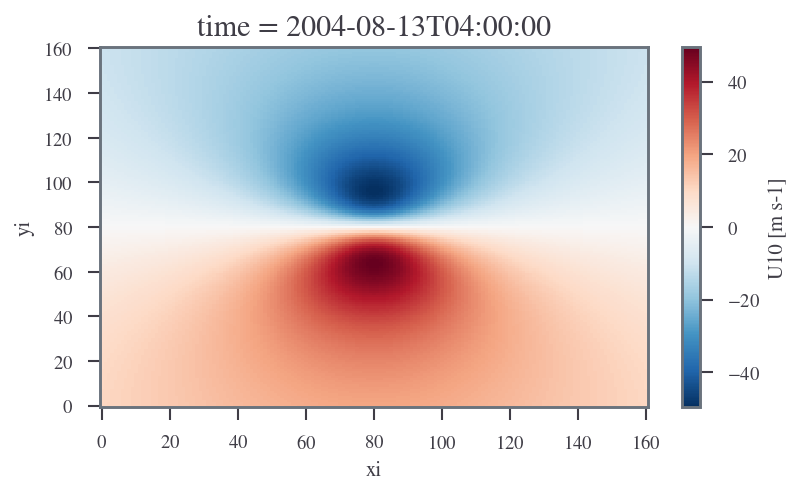

In [15]:
f22["TC1"]["U10"].isel(time=400).plot()

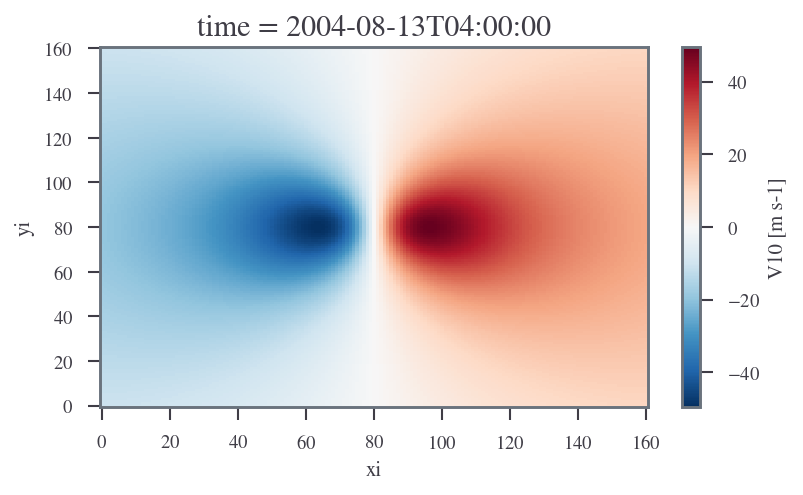

In [16]:
f22["TC1"]["V10"].isel(time=400).plot()

In [17]:
from src.constants import NO_BBOX
import pandas as pd
from sithom.plot import plot_defaults, lim
from sithom.xr import plot_units
from adforce.mesh import bbox_mesh

plot_defaults()

def plot_quiver_height(path_in: str = "mult1", time_i: int = 160, x_pos: float = 0.95, y_pos: float = -0.15) -> None:
    """
    Plot quiver height.

    Args:
        path_in (str, optional): name of data folder. Defaults to "mult1".
        time_i (int, optional): time_i. Defaults to 185.
    """
    # path_in = os.path.join(DATA_PATH, path_in)
    ds = bbox_mesh(os.path.join(path_in, "fort.63.nc"), bbox=NO_BBOX.pad(0.3), use_dask=True)
    print(ds)
    vmin, vmax = ds.zeta.min().values, ds.zeta.max().values
    vmin, vmax = np.min([-vmax, vmin]), np.max([-vmin, vmax])
    print(vmin, vmax)
    levels = np.linspace(vmin, vmax, num=400)
    cbar_levels = np.linspace(vmin, vmax, num=5)
    plt.tricontourf(
            ds.x.values,
            ds.y.values,
            ds.element.values -1,
            np.nan_to_num(ds.zeta.isel(time=time_i).values,copy=False, nan=0),
            vmin=vmin,
            vmax=vmax,
            levels=levels,
            cmap="cmo.balance",
        )
    ax = plt.gca()
    cbar = plt.colorbar(label="Height [m]")
    cbar.set_ticks(cbar_levels)
    cbar.set_ticklabels(["{:.2f}".format(x) for x in cbar_levels.tolist()])
    plt.xlabel("Longitude [$^{\circ}$E]")
    plt.ylabel("Latitude [$^{\circ}$N]")
    time = ds.isel(time=time_i).time.values
    ts = pd.to_datetime(str(time))
    print(ts)
    # plt.savefig(os.path.join(output_path, str(time_i) + ".png"))
    # plt.clf()
    ds = read_fort22(os.path.join(path_in, "fort.22.nc"))["Main"].to_dataset()
    print(ds)
    quiver = plot_units(
        ds.sel(time=time, method="nearest"), 
        x_dim="lon", 
        y_dim="lat"
    ).plot.quiver(
        ax=ax,
        x="lon",
        y="lat",
        u="U10",
        v="V10",
        add_guide=False,
    )
    _ = plt.quiverkey(
        quiver,
        # 1.08,
        x_pos,
        y_pos,  # 08,
        40,
        str(r"$40$ m s$^{-1}$"),  # + "\n"
        labelpos="E",
        coordinates="axes",
        # coordinates="figure"
    )
    NO_BBOX.ax_lim(plt.gca())
    plt.title(ts.strftime("%Y-%m-%d  %H:%M"))
    # plt.savefig(os.path.join(FIGURE_PATH, "example_colision.png"))
    # plt.clf()

'xr_loader'  0.01494 s 

'filter_mesh'  0.52151 s 

'bbox_mesh'  4.00108 s 

<xarray.Dataset>
Dimensions:      (time: 336, node: 233971, mesh: 1, nope: 2, neta: 122,
                  nbou: 15, nvel: 8316, nele: 465356, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2004-08-01T01:00:00 ... 2004-08-15
    x            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
    y            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nvdll        (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    max_nvdll    int32 ...
    ibtypee      (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    nbdv         (neta) int32 dask.array<chunksize=(122,), meta=np.ndarray>
    nvell        (nbou) int32 dask.array<chunksize=(15,), meta=n

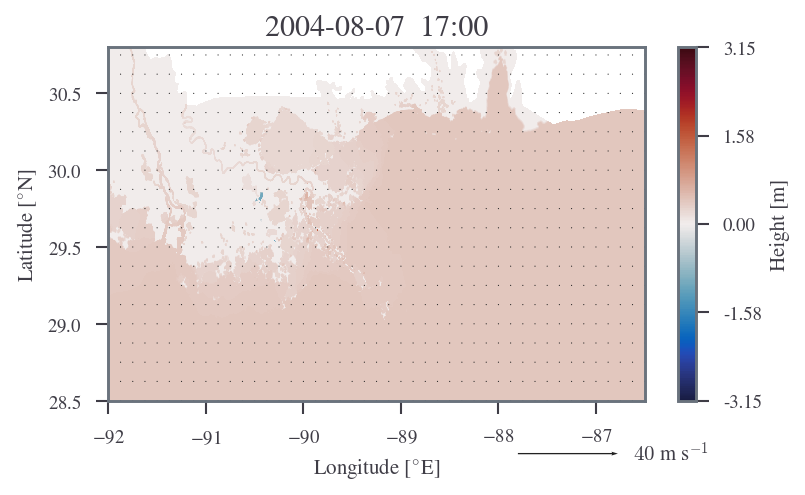

In [18]:
plot_quiver_height("../../kat.nws13.2004")

'xr_loader'  0.58000 s 

'filter_mesh'  0.53351 s 

'bbox_mesh'  1.13160 s 

<xarray.Dataset>
Dimensions:      (time: 168, node: 233971, mesh: 1, nope: 2, neta: 122,
                  nbou: 15, nvel: 8316, nele: 465356, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2014-04-29T01:00:00 ... 2014-05-06
    x            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
    y            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nvdll        (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    max_nvdll    int32 ...
    ibtypee      (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    nbdv         (neta) int32 dask.array<chunksize=(122,), meta=np.ndarray>
    nvell        (nbou) int32 dask.array<chunksize=(15,), meta=n

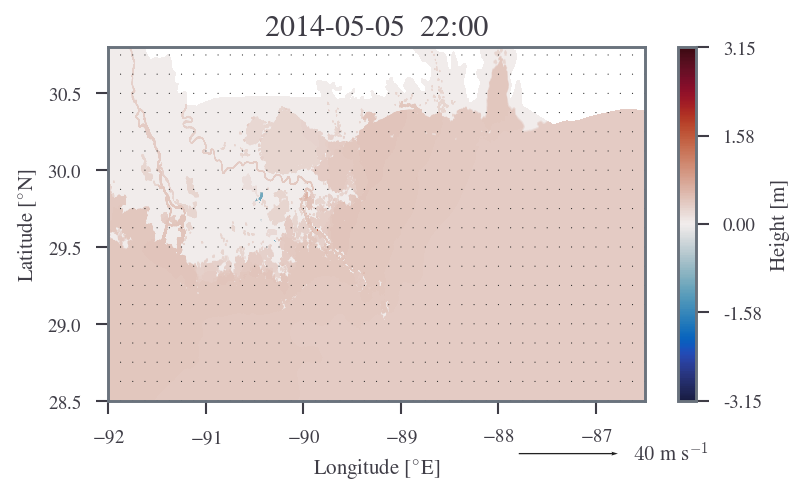

In [19]:
plot_quiver_height("../../kat.nws13", time_i=165)

'xr_loader'  0.01459 s 

'filter_mesh'  0.47308 s 

'bbox_mesh'  0.49206 s 

<xarray.Dataset>
Dimensions:      (time: 336, node: 233971, mesh: 1, nope: 2, neta: 122,
                  nbou: 15, nvel: 8316, nele: 465356, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2004-08-01T01:00:00 ... 2004-08-15
    x            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
    y            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nvdll        (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    max_nvdll    int32 ...
    ibtypee      (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    nbdv         (neta) int32 dask.array<chunksize=(122,), meta=np.ndarray>
    nvell        (nbou) int32 dask.array<chunksize=(15,), meta=n

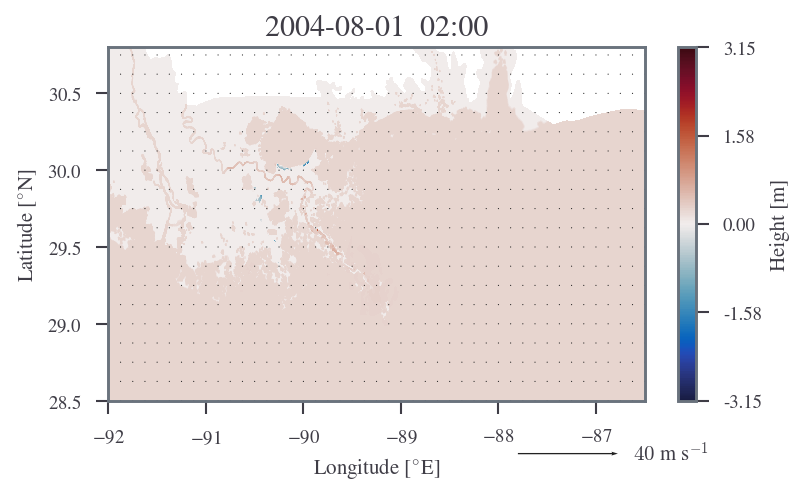

In [20]:
plot_quiver_height("../../kat.nws13.2004", time_i=1)

In [21]:
ds = bbox_mesh(os.path.join("../../kat.nws13.2004", "fort.63.nc"), bbox=NO_BBOX)

'xr_loader'  0.01440 s 

'filter_mesh'  0.44596 s 

'bbox_mesh'  0.46545 s 



'xr_loader'  0.01518 s 

'filter_mesh'  0.48579 s 

'bbox_mesh'  0.50515 s 

<xarray.Dataset>
Dimensions:      (time: 336, node: 233971, mesh: 1, nope: 2, neta: 122,
                  nbou: 15, nvel: 8316, nele: 465356, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2004-08-01T01:00:00 ... 2004-08-15
    x            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
    y            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nvdll        (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    max_nvdll    int32 ...
    ibtypee      (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    nbdv         (neta) int32 dask.array<chunksize=(122,), meta=np.ndarray>
    nvell        (nbou) int32 dask.array<chunksize=(15,), meta=n

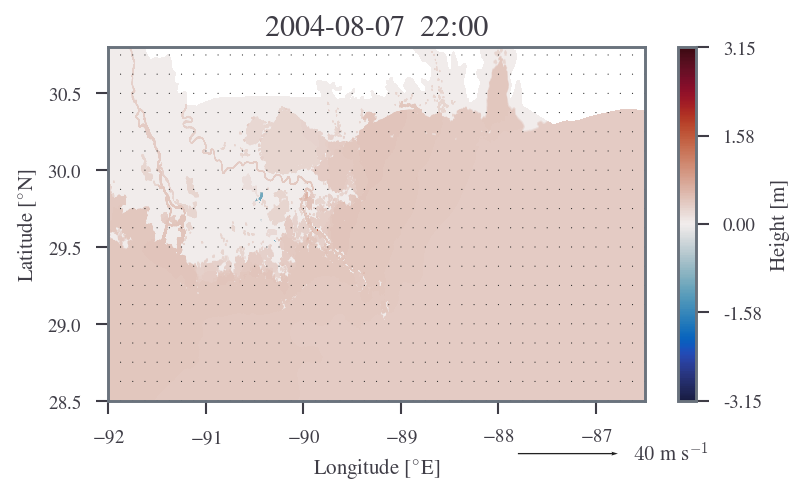

In [22]:
plot_quiver_height("../../kat.nws13.2004", time_i=165)

In [25]:
from src.constants import NO_BBOX
import pandas as pd
from sithom.plot import plot_defaults, lim
from sithom.xr import plot_units
from adforce.mesh import bbox_mesh
from sithom.time import timeit

plot_defaults()


@timeit
def plot_quiver_pressure(
    path_in: str = "mult1", time_i: int = 160, x_pos: float = 0.95, y_pos: float = -0.15
) -> None:
    """
    Plot quiver pressure.

    Args:
        path_in (str, optional): name of data folder. Defaults to "mult1".
        time_i (int, optional): time_i. Defaults to 185.
    """
    # path_in = os.path.join(DATA_PATH, path_in)
    ds = read_fort22(os.path.join(path_in, "fort.22.nc"))["Main"].to_dataset()
    vmin, vmax = ds.PSFC.min().values, ds.PSFC.max().values
    # vmin, vmax = np.min([-vmax, vmin]), np.max([-vmin, vmax])
    # print(vmin, vmax)
    levels = np.linspace(vmin, vmax, num=400)
    cbar_levels = np.linspace(vmin, vmax, num=5)
    im = plt.contourf(
        ds.lon.values,
        ds.lat.values,
        ds.PSFC.isel(time=time_i).values,
        levels=levels,
        cmap="cmo.amp_r",
        vmin=vmin,
        vmax=vmax,
    )
    ax = plt.gca()
    cbar = plt.colorbar(label="PSFC, $P$ [mbar]")
    cbar.set_ticks(cbar_levels)
    cbar.set_ticklabels(["{:.0f}".format(x) for x in cbar_levels.tolist()])
    plt.xlabel("Longitude [$^{\circ}$E]")
    plt.ylabel("Latitude [$^{\circ}$N]")
    time = ds.isel(time=time_i).time.values
    ts = pd.to_datetime(str(time))
    print(ts)
    quiver = plot_units(
        ds.isel(time=time_i), x_dim="lon", y_dim="lat"
    ).plot.quiver(
        ax=ax,
        x="lon",
        y="lat",
        u="U10",
        v="V10",
        add_guide=False,
    )
    _ = plt.quiverkey(
        quiver,
        x_pos,
        y_pos,
        40,
        str(r"$40$ m s$^{-1}$"),  # + "\n"
        labelpos="E",
        coordinates="axes",
        # coordinates="figure"
    )
    NO_BBOX.ax_lim(plt.gca())
    plt.title(ts.strftime("%Y-%m-%d  %H:%M"))
    # plt.savefig(os.path.join(FIGURE_PATH, "example_colision.png"))
    # plt.clf()
    plt.scatter(NEW_ORLEANS.lon, 
                NEW_ORLEANS.lat, 
                marker=".", 
                color="purple", 
                label="New Orleans")


0
2004-08-09 00:00:00
'plot_quiver_pressure'  0.83588 s 



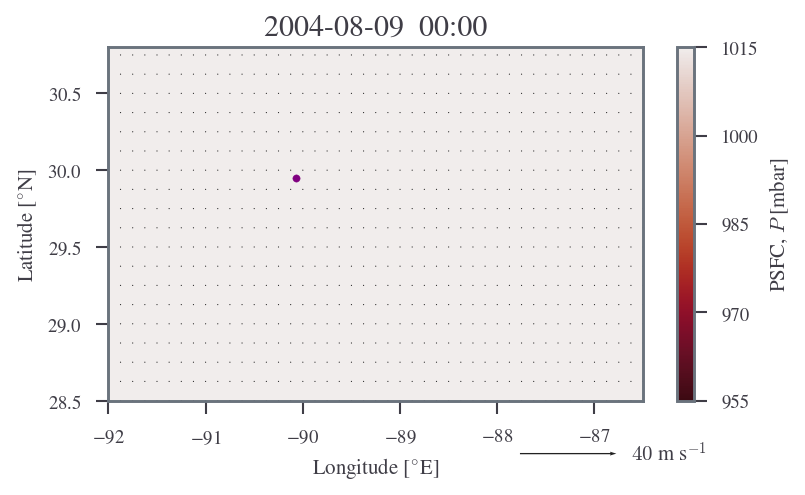

1
2004-08-10 01:00:00
'plot_quiver_pressure'  0.93747 s 



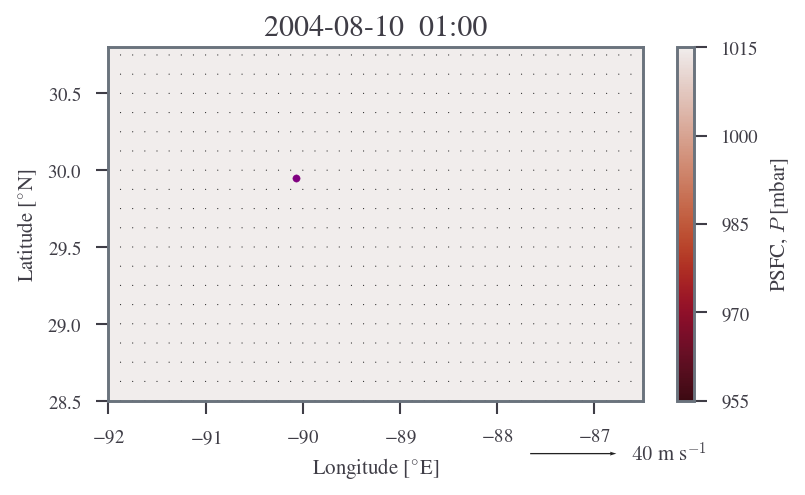

2
2004-08-11 02:00:00
'plot_quiver_pressure'  0.89422 s 



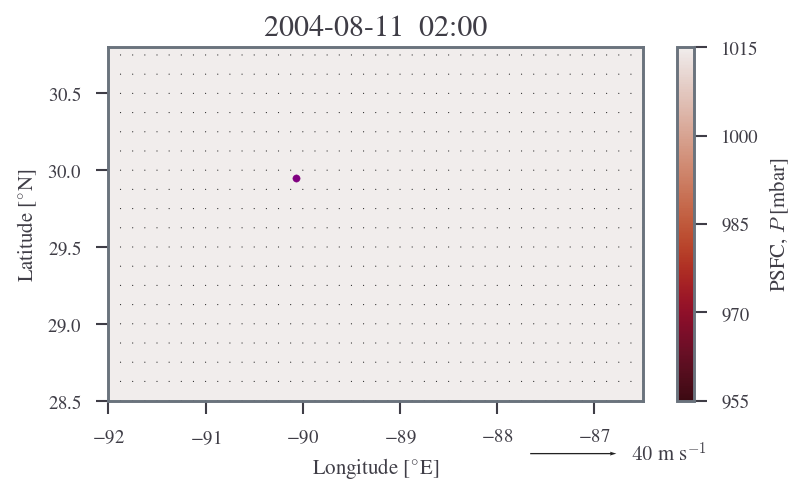

3
2004-08-12 03:00:00
'plot_quiver_pressure'  0.92169 s 



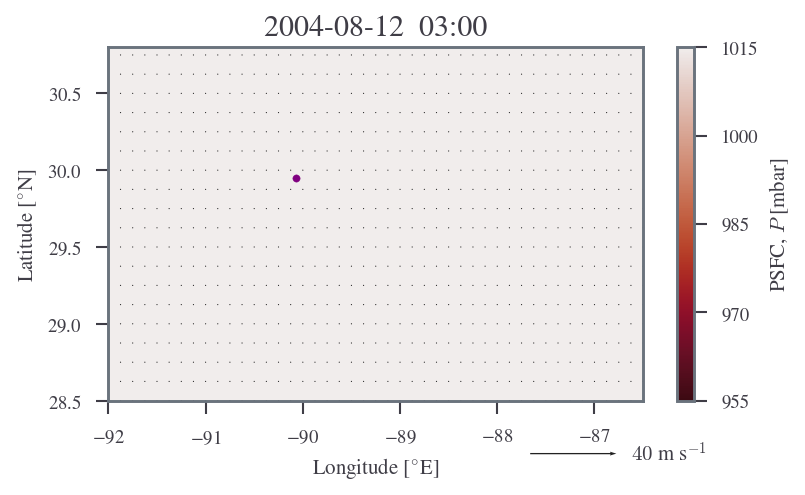

4
2004-08-13 04:00:00
'plot_quiver_pressure'  0.92313 s 



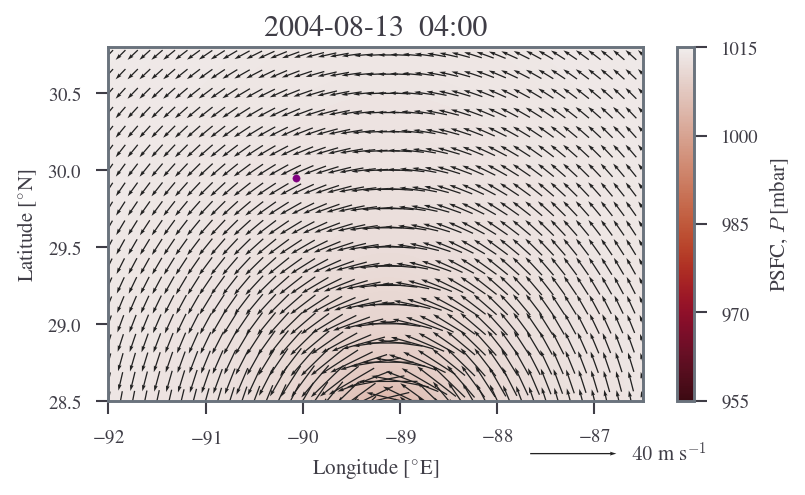

5
2004-08-14 05:00:00
'plot_quiver_pressure'  0.90707 s 



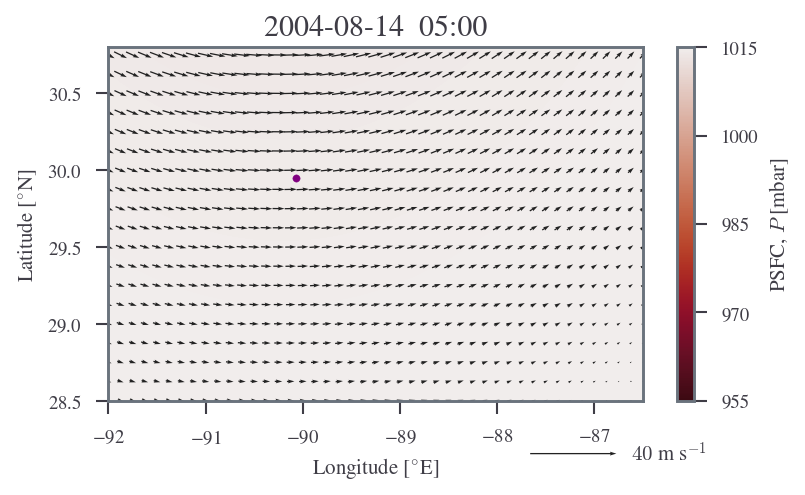

6
2004-08-15 06:00:00
'plot_quiver_pressure'  0.92811 s 



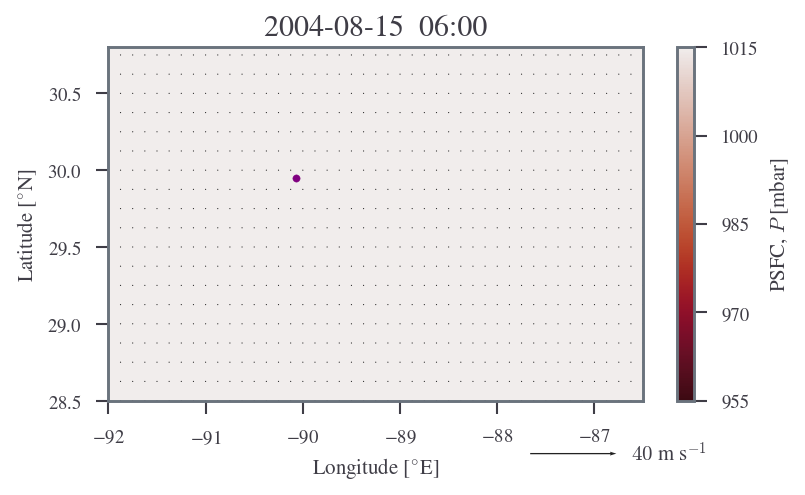

In [26]:
for i in range(0, 7):
    print(i)
    plot_quiver_pressure("../../exp/angle_test/exp_004", time_i=i*100)
    plt.show()

In [27]:
folder = "../../kat.nws13.2004/"
img_folder = os.path.join(folder, "img")
os.makedirs(img_folder, exist_ok=True)
figure_names = []

for i in range(0, 68):
    plot_quiver_pressure(folder, time_i=i * 10)
    figure_name = os.path.join(img_folder, f"pressure_{i:04}.png")
    plt.savefig(figure_name)
    figure_names.append(figure_name)
    plt.clf()

print(figure_names)

2004-08-09 00:00:00
'plot_quiver_pressure'  1.14514 s 

2004-08-09 02:30:00
'plot_quiver_pressure'  0.90520 s 

2004-08-09 05:00:00
'plot_quiver_pressure'  0.92324 s 

2004-08-09 07:30:00
'plot_quiver_pressure'  0.90980 s 

2004-08-09 10:00:00
'plot_quiver_pressure'  0.90774 s 

2004-08-09 12:30:00
'plot_quiver_pressure'  0.89005 s 

2004-08-09 15:00:00
'plot_quiver_pressure'  0.92085 s 

2004-08-09 17:30:00
'plot_quiver_pressure'  0.91928 s 

2004-08-09 20:00:00
'plot_quiver_pressure'  0.94924 s 

2004-08-09 22:30:00
'plot_quiver_pressure'  0.91898 s 

2004-08-10 01:00:00
'plot_quiver_pressure'  0.90257 s 

2004-08-10 03:30:00
'plot_quiver_pressure'  0.90639 s 

2004-08-10 06:00:00
'plot_quiver_pressure'  0.90252 s 

2004-08-10 08:30:00
'plot_quiver_pressure'  0.89156 s 

2004-08-10 11:00:00
'plot_quiver_pressure'  0.90287 s 

2004-08-10 13:30:00
'plot_quiver_pressure'  1.06303 s 

2004-08-10 16:00:00
'plot_quiver_pressure'  0.91044 s 

2004-08-10 18:30:00
'plot_quiver_pressure'  0.90

<Figure size 826.772x510.973 with 0 Axes>

In [28]:
figure_names

['../../kat.nws13.2004/img/pressure_0000.png',
 '../../kat.nws13.2004/img/pressure_0001.png',
 '../../kat.nws13.2004/img/pressure_0002.png',
 '../../kat.nws13.2004/img/pressure_0003.png',
 '../../kat.nws13.2004/img/pressure_0004.png',
 '../../kat.nws13.2004/img/pressure_0005.png',
 '../../kat.nws13.2004/img/pressure_0006.png',
 '../../kat.nws13.2004/img/pressure_0007.png',
 '../../kat.nws13.2004/img/pressure_0008.png',
 '../../kat.nws13.2004/img/pressure_0009.png',
 '../../kat.nws13.2004/img/pressure_0010.png',
 '../../kat.nws13.2004/img/pressure_0011.png',
 '../../kat.nws13.2004/img/pressure_0012.png',
 '../../kat.nws13.2004/img/pressure_0013.png',
 '../../kat.nws13.2004/img/pressure_0014.png',
 '../../kat.nws13.2004/img/pressure_0015.png',
 '../../kat.nws13.2004/img/pressure_0016.png',
 '../../kat.nws13.2004/img/pressure_0017.png',
 '../../kat.nws13.2004/img/pressure_0018.png',
 '../../kat.nws13.2004/img/pressure_0019.png',
 '../../kat.nws13.2004/img/pressure_0020.png',
 '../../kat.n

In [29]:
import imageio

with imageio.get_writer(os.path.join(folder, "pressure.gif"), mode="I") as writer:
    for filename in figure_names:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_107793/1969943677.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [30]:
from src.constants import NO_BBOX
import pandas as pd
from sithom.plot import plot_defaults, lim
from sithom.xr import plot_units
from adforce.mesh import bbox_mesh

plot_defaults()


@timeit
def plot_heights(
    path_in: str = "mult1",
    step_size: int = 1,
) -> None:
    """
    Plot heights.

    Args:
        path_in (str, optional): name of data folder. Defaults to "mult1".
        step_size (int, optional): step size. Defaults to 1.
    """
    img_folder = os.path.join(path_in, "img")
    os.makedirs(img_folder, exist_ok=True)
    figure_names = []
    # path_in = os.path.join(DATA_PATH, path_in)
    ds = bbox_mesh(
        os.path.join(path_in, "fort.63.nc"), bbox=NO_BBOX.pad(0.3), use_dask=True
    )
    vmin, vmax = ds.zeta.min().values, ds.zeta.max().values
    vmin, vmax = np.min([-vmax, vmin]), np.max([-vmin, vmax])
    print(vmin, vmax)
    levels = np.linspace(vmin, vmax, num=400)
    cbar_levels = np.linspace(vmin, vmax, num=5)

    for time_i in range(0, len(ds.time.values), step_size):
        plt.tricontourf(
            ds.x.values,
            ds.y.values,
            ds.element.values - 1,
            np.nan_to_num(ds.zeta.isel(time=time_i).values, copy=False, nan=0),
            vmin=vmin,
            vmax=vmax,
            levels=levels,
            cmap="cmo.balance",
        )
        ax = plt.gca()
        cbar = plt.colorbar(label="Height [m]")
        cbar.set_ticks(cbar_levels)
        cbar.set_ticklabels(["{:.2f}".format(x) for x in cbar_levels.tolist()])
        plt.xlabel("Longitude [$^{\circ}$E]")
        plt.ylabel("Latitude [$^{\circ}$N]")
        time = ds.isel(time=time_i).time.values
        ts = pd.to_datetime(str(time))
        print(ts)
        plt.scatter(NEW_ORLEANS.lon, 
                    NEW_ORLEANS.lat, 
                    marker=".", 
                    color="purple", 
                    label="New Orleans")
        NO_BBOX.ax_lim(plt.gca())
        ax.set_aspect("equal")
        plt.title(ts.strftime("%Y-%m-%d  %H:%M"))
        figure_name = os.path.join(img_folder, f"height_{time_i:04}.png")
        plt.savefig(figure_name)
        figure_names.append(figure_name)
        plt.clf()

    gif_name = os.path.join(path_in, "height.gif")
    print("gif_name", gif_name)

    with imageio.get_writer(gif_name, mode="I") as writer:
        for filename in figure_names:
            image = imageio.imread(filename)
            writer.append_data(image)

In [31]:
plot_heights("../../kat.nws13.2004/")

'xr_loader'  0.02843 s 

'filter_mesh'  0.49851 s 

'bbox_mesh'  0.53294 s 

-3.1529049 3.1529049
2004-08-01 01:00:00
2004-08-01 02:00:00
2004-08-01 03:00:00
2004-08-01 04:00:00
2004-08-01 05:00:00
2004-08-01 06:00:00
2004-08-01 07:00:00


In [ ]:
plot_heights("../../NWS13example/", step_size=10)
# plot_heights("../../NWS13example/")

'xr_loader'  0.01569 s 

'filter_mesh'  0.02292 s 

'bbox_mesh'  0.04199 s 

-2.249639403405712 2.249639403405712
2014-04-29 00:10:00
2014-04-29 01:50:00
2014-04-29 03:30:00
2014-04-29 05:10:00
2014-04-29 06:50:00
2014-04-29 08:30:00
2014-04-29 10:10:00
2014-04-29 11:50:00
2014-04-29 13:30:00
2014-04-29 15:10:00
2014-04-29 16:50:00
2014-04-29 18:30:00
2014-04-29 20:10:00
2014-04-29 21:50:00
2014-04-29 23:30:00
2014-04-30 01:10:00
2014-04-30 02:50:00
2014-04-30 04:30:00
2014-04-30 06:10:00
2014-04-30 07:50:00
2014-04-30 09:30:00
2014-04-30 11:10:00
2014-04-30 12:50:00
2014-04-30 14:30:00
2014-04-30 16:10:00
2014-04-30 17:50:00
2014-04-30 19:30:00
2014-04-30 21:10:00
2014-04-30 22:50:00
2014-05-01 00:30:00
2014-05-01 02:10:00
2014-05-01 03:50:00
2014-05-01 05:30:00
2014-05-01 07:10:00
2014-05-01 08:50:00
2014-05-01 10:30:00
2014-05-01 12:10:00
2014-05-01 13:50:00
2014-05-01 15:30:00
2014-05-01 17:10:00
2014-05-01 18:50:00
2014-05-01 20:30:00
2014-05-01 22:10:00
2014-05-01 23:50:00
2014-0

/tmp/ipykernel_5042/3550393460.py:70: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


'plot_heights'  58.47871 s 



<Figure size 826.772x510.973 with 0 Axes>